# Simple Linear Regression (Time Series Forecasting)
### The goal of Simple Linear Regression is to create a linear model that minimizes the sum of squares of residuals. The two main objectives are to establish if there is a relationship between two variables and to forecast new observations. 
### y = mx+c+e

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv("data/bookings.csv", low_memory=False)

In [3]:
df.created_at = pd.to_datetime(df.created_at)
df.set_index(df.created_at, inplace=True)

In [4]:
# resampling works better for date indexes
# This is also because if there are no records for a particular day, this will create the day 
# but insert 0. When days are shifted or differentiated, it also makes sense because it will allow
# shifting appropriate days (ie, if shifted by 7, mondays will be shifted by monday).
dfCount = pd.DataFrame({'total_count' : df.resample('D').size()})

In [5]:
dfCount.head(5)

,total_count
created_at,
2016-09-26,1
2016-09-27,0
2016-09-28,2
2016-09-29,0
2016-09-30,0


In [6]:
dfCount.describe()

,total_count
count,828.000000
mean,716.764493
std,805.266185
min,0.000000
25%,47.750000
50%,391.000000
75%,1243.750000
max,3860.000000


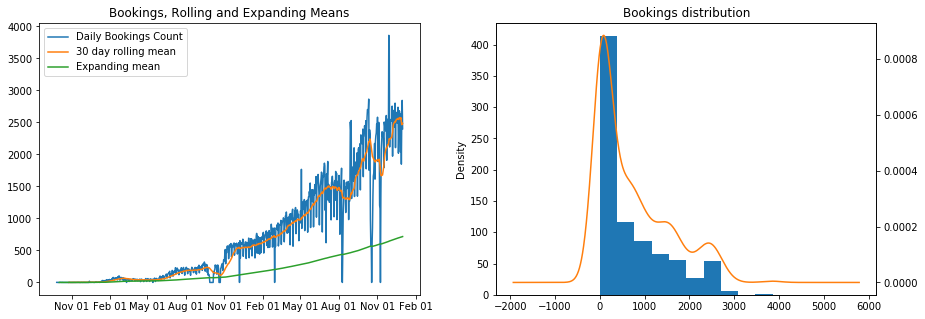

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize= (15,5))
ax[0].plot(dfCount, label="Daily Bookings Count")
ax[0].plot(dfCount.rolling(window=30).mean(), label='30 day rolling mean')
ax[0].plot(dfCount.expanding(min_periods=7).mean(), label='Expanding mean')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[0].legend(loc='upper left')
dfCount.total_count.plot(kind='hist', ax=ax[1])
dfCount.total_count.plot(kind='kde', ax=ax[1], secondary_y=True)
ax[0].set_title("Bookings, Rolling and Expanding Means")
ax[1].set_title("Bookings distribution")
plt.show()

### Lag-K autocorrelation in a time series = correlation between values that are k periods apart. 
#### Auto correlation shows that the days closer are more correlated compared to further away. This data is not time independent.  

C:\Users\ayush.LAPTOP-A9620OED\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


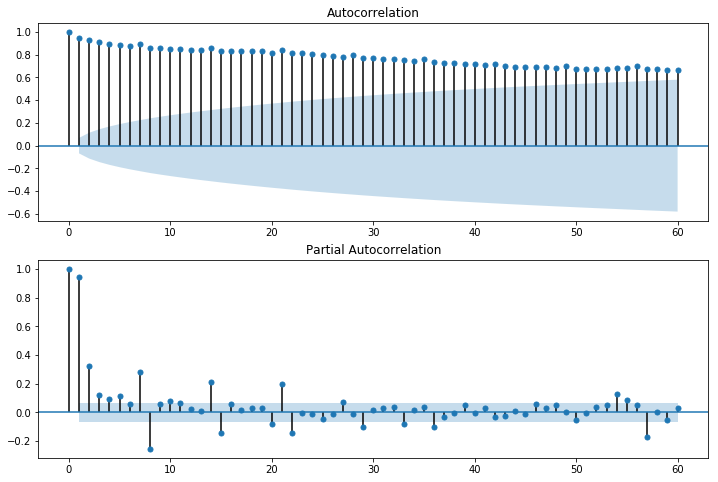

In [8]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfCount.total_count, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfCount.total_count, lags=60, ax=ax2)
plt.show()

In [10]:
dfCountFiltered = dfCount.copy()

## As It Is decomposition

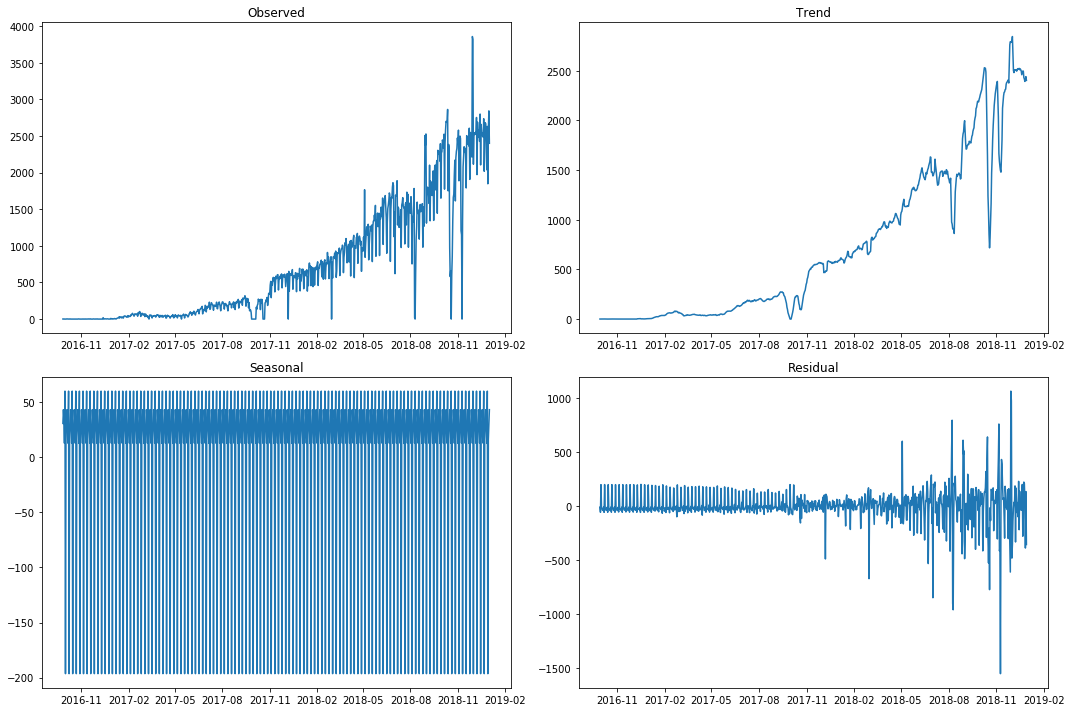

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

dfCountFiltered.interpolate(inplace = True)
decomposition = seasonal_decompose(dfCountFiltered, model = 'additive', freq=7)

fig, ax = plt.subplots(nrows = 2, ncols=2, figsize= (15,10))
ax[0 ,0].plot(decomposition.observed)
ax[0, 1].plot(decomposition.trend)
ax[1, 0].plot(decomposition.seasonal)
ax[1, 1].plot(decomposition.resid)
ax[0, 0].set_title("Observed")
ax[0, 1].set_title("Trend")
ax[1, 0].set_title("Seasonal")
ax[1, 1].set_title("Residual")
fig.tight_layout()
plt.show()

## Augmented Dickey-Fuller unit root test
### The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
### Stationary Test
#### After trend and seasonality is removed, residual data can be checked for stationarity using Dickey Fuller unit root test)


#### A time series is stationary if, and only if, its mean does not depend on time, its variance is constant and also does not depend on time, and the autocorrelation does not vary either. This means that any time process with a trend and seasonality is not stationary. Trends can result in a varying mean over time, whereas seasonality can result in a changing variance over time, both which define a time series as being non-stationary. Stationary datasets are those that have a stable mean and variance, and are in turn much easier to model.

In [12]:
from statsmodels.tsa.stattools import adfuller
residual = decomposition.resid
residual.dropna(inplace=True)
print('p value: ', adfuller(residual.total_count, autolag = 'AIC', regression = 'ct')[1])

p value:  8.399967451064249e-21


### P value is statistically significant. 

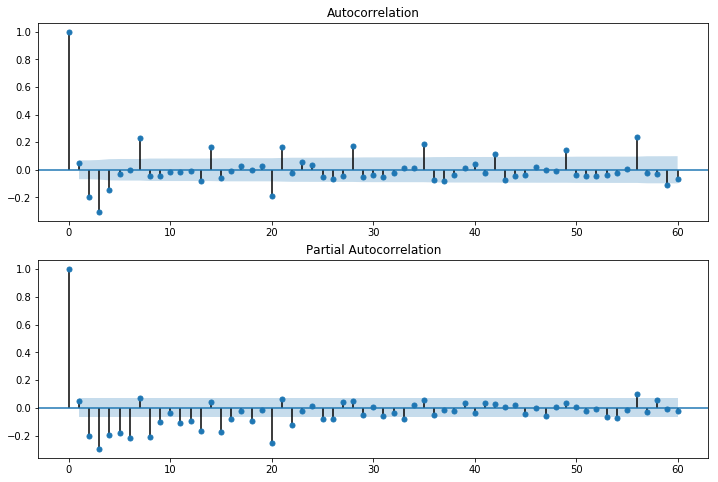

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(decomposition.resid, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(decomposition.resid, lags=60, ax=ax2)

In [14]:
# outliers (keeping data that are withing 3 std deviations from the mean)
# dfCountStdFiltered = dfCountFiltered[np.abs(dfCountFiltered.total_count-dfCountFiltered.total_count.mean())<=(3*dfCountFiltered.total_count.std())]
# again nothing changed here because did not want to get rid of dates on second thought
dfCountStdFiltered = dfCountFiltered.copy()
dfCountStdFiltered.describe()

,total_count
count,828.000000
mean,716.764493
std,805.266185
min,0.000000
25%,47.750000
50%,391.000000
75%,1243.750000
max,3860.000000


#### Nothing really changed here

## Detrending by Differencing
#### value(t) = observation(t) - observation(t-1)
#### This is a one to one mapping. This is necessary because we will have to retrofit trend back in the model.

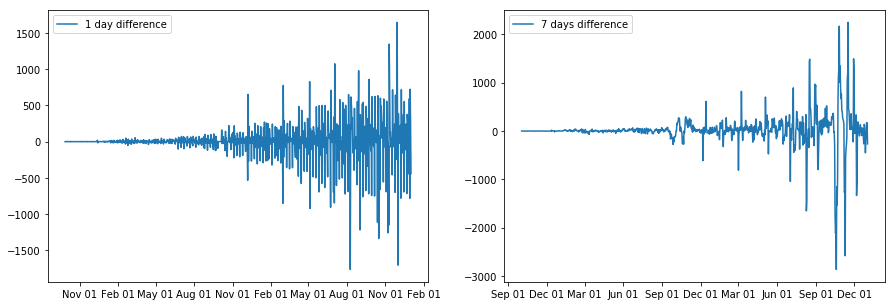

In [15]:
dfCountDiff1 = dfCountStdFiltered.diff(1)
# Basically differencing each day of the week with previous same day of the week
# Does not work because some days were removed completely
dfCountDiff7 = dfCountStdFiltered.diff(7)
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize= (15,5))
ax[0].plot(dfCountDiff1, label = "1 day difference")
ax[0].legend(loc='upper left')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[1].plot(dfCountDiff7, label = "7 days difference")
ax[1].legend(loc='upper left')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

## Detrending by Regression
#### value(t) = observation(t) - prediction(t)

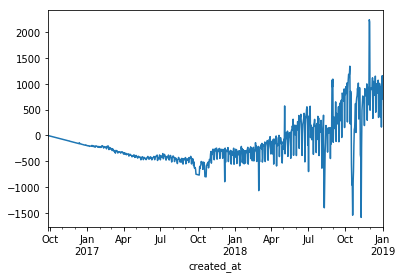

In [16]:
from statsmodels.regression.linear_model import OLS
model = OLS(dfCountStdFiltered.total_count.values, list(range(len(dfCountStdFiltered.values))))
result = model.fit()
result.params
fit = pd.Series(result.predict(list(range(len(dfCountStdFiltered.values)))), index = dfCountStdFiltered.index)

dfCount_detrended = dfCountStdFiltered.total_count - fit
dfCount_detrended.plot()
plt.show()

## Detrending by difference in Rolling Mean

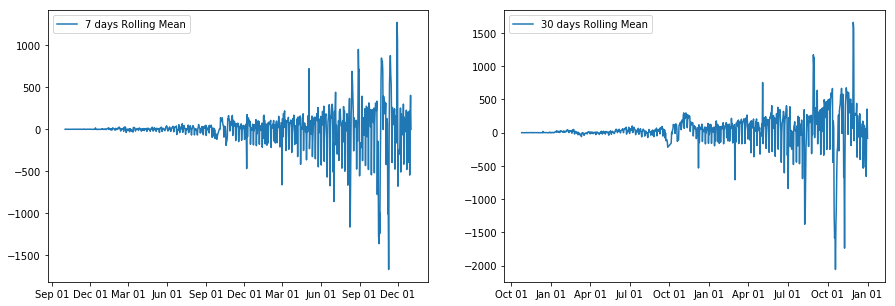

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize= (15,5))
ax[0].plot(dfCountStdFiltered - dfCountStdFiltered.rolling(window = 7).mean(), label = "7 days Rolling Mean")
ax[0].legend(loc='upper left')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[1].plot(dfCountStdFiltered - dfCountStdFiltered.rolling(window = 30).mean(), label = "30 days Rolling Mean")
ax[1].legend(loc='upper left')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

In [18]:
dfCountStdFiltered.head()

,total_count
created_at,
2016-09-26,1
2016-09-27,0
2016-09-28,2
2016-09-29,0
2016-09-30,0


## Detrending by difference in Rolling Mean of Log values/SQRT values
#### A power or log transformation punishes larger values more than smaller values. Since we have 0 in our dataframe, lets use sqrt

In [19]:
dfCountStdFilteredSqrt = dfCountStdFiltered.apply(lambda x: np.sqrt(x))

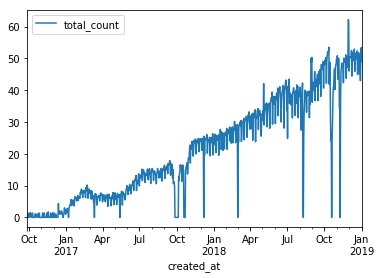

In [20]:
dfCountStdFilteredSqrt.plot()
plt.show()

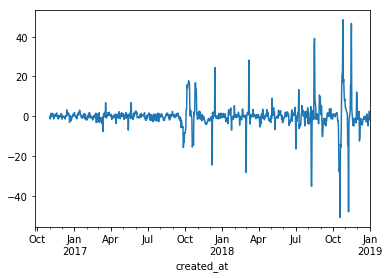

In [21]:
dfCountStdFilteredSqrt['trend_removed'] = dfCountStdFilteredSqrt.total_count - dfCountStdFilteredSqrt.total_count.rolling(window = 30).mean()
dfCountStdFilteredSqrt['seasonality_removed'] = dfCountStdFilteredSqrt.total_count - dfCountStdFilteredSqrt.total_count.shift(7)
dfCountStdFilteredSqrt['residual'] = dfCountStdFilteredSqrt.trend_removed - dfCountStdFilteredSqrt.trend_removed.shift(7)
dfCountStdFilteredSqrt.residual.plot()
plt.show()

In [22]:
dfCountStdFilteredSqrt.dropna(inplace=True)
print('p value: ', adfuller(dfCountStdFilteredSqrt.residual, autolag = 'AIC', regression = 'ct')[1])

p value:  2.7820517244325322e-09


### For our purposes, we will use detrending by rolling mean

In [23]:
dfCountStdFiltered['trend_removed'] = dfCountStdFiltered.total_count - dfCountStdFiltered.total_count.rolling(window = 30).mean()

In [24]:
dfCountStdFiltered['seasonality_removed'] = dfCountStdFiltered.total_count - dfCountStdFiltered.total_count.shift(7)

In [25]:
dfCountStdFiltered['residual'] = dfCountStdFiltered.trend_removed - dfCountStdFiltered.trend_removed.shift(7)

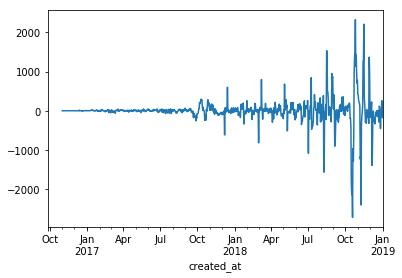

In [26]:
dfCountStdFiltered.residual.plot()
plt.show()

In [27]:
dfCountStdFiltered.dropna(inplace=True)
print('p value: ', adfuller(dfCountStdFiltered.residual, autolag = 'AIC', regression = 'ct')[1])

p value:  5.047127502409889e-09


### Passes the stationary test

In [28]:
dfCountStdFiltered

,total_count,trend_removed,seasonality_removed,residual
created_at,,,,
2016-11-01,0,-0.600000,0.0,0.000000
2016-11-02,0,-0.533333,-2.0,-1.900000
2016-11-03,0,-0.500000,-1.0,-0.833333
2016-11-04,2,1.500000,2.0,2.100000
2016-11-05,0,-0.466667,0.0,0.133333
2016-11-06,0,-0.466667,0.0,0.133333
2016-11-07,0,-0.433333,0.0,0.166667
2016-11-08,2,1.500000,2.0,2.100000
2016-11-09,0,-0.433333,0.0,0.100000


## Simple Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
model = LinearRegression().fit(dfCountStdFiltered.index.factorize()[0].reshape(-1,1), dfCountStdFiltered.residual)
m = model.coef_[0]
b = model.intercept_
print ('y = ', round(m, 5), 'x +', round(b ,2))

y =  -0.01404 x + 4.5


In [31]:
predictions = model.predict(dfCountStdFiltered.index.factorize()[0].reshape(-1,1))

In [32]:
dfPredictions = pd.DataFrame(data=predictions, index=dfCountStdFiltered.index.values, columns=['predictions'])

In [33]:
dfPredictions.head()

,predictions
2016-11-01,4.503853
2016-11-02,4.489816
2016-11-03,4.475779
2016-11-04,4.461742
2016-11-05,4.447704


In [34]:
dfJoined = dfCountStdFiltered.join(dfPredictions, how = 'inner')

In [35]:
dfJoined.head()

,total_count,trend_removed,seasonality_removed,residual,predictions
created_at,,,,,
2016-11-01,0,-0.600000,0.0,0.000000,4.503853
2016-11-02,0,-0.533333,-2.0,-1.900000,4.489816
2016-11-03,0,-0.500000,-1.0,-0.833333,4.475779
2016-11-04,2,1.500000,2.0,2.100000,4.461742
2016-11-05,0,-0.466667,0.0,0.133333,4.447704


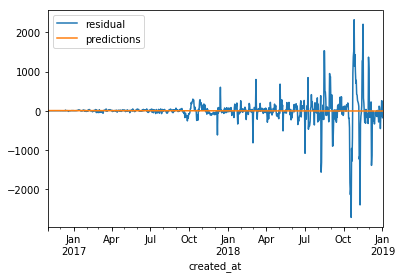

In [36]:
dfJoined[['residual', 'predictions']].plot()
plt.show()

In [37]:
model_LIB = LinearRegression().fit(decomposition.resid.index.factorize()[0].reshape(-1,1), decomposition.resid.total_count)
m_LIB = model_LIB.coef_[0]
b_LIB = model_LIB.intercept_
print ('y = ', round(m_LIB, 5), 'x +', round(b_LIB ,2))

y =  -0.00319 x + 0.95


In [38]:
predictionsLIB = model_LIB.predict(decomposition.resid.total_count.values.reshape(-1,1))

In [39]:
dfPredictions = pd.DataFrame(data=predictionsLIB, index=decomposition.resid.index.values, columns=['predictions_LIB'])

In [40]:
dfJoined2 = dfJoined.join(dfPredictions, how = 'inner')

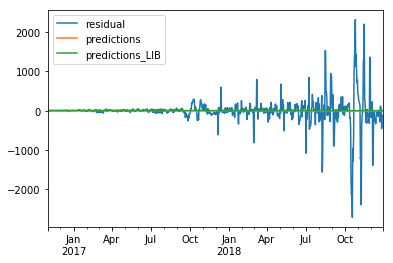

In [41]:
dfJoined2[['residual', 'predictions', 'predictions_LIB']].plot()
plt.show()

In [42]:
dfJoined2.head()

,total_count,trend_removed,seasonality_removed,residual,predictions,predictions_LIB
2016-11-01,0,-0.600000,0.0,0.000000,4.503853,1.085024
2016-11-02,0,-0.533333,-2.0,-1.900000,4.489816,1.059668
2016-11-03,0,-0.500000,-1.0,-0.833333,4.475779,0.987972
2016-11-04,2,1.500000,2.0,2.100000,4.461742,1.132319
2016-11-05,0,-0.466667,0.0,0.133333,4.447704,0.321928


#### The point of adding linear regression from my model and from the model built by the library was to check for differences. They seem to overlap. Since the next step would be to retrofit trend and seasonality back, the mapping needs to be one to one. Not sure if one to one mapping can be used from data generated from the library since it seems more or less a blackbox at the moment. In my model however, since differences of the rolling mean and shiftting was used to remove trend and seasonality, it should be reversible. 

#### Lag-K autocorrelation in a time series = correlation between values that are k periods apart

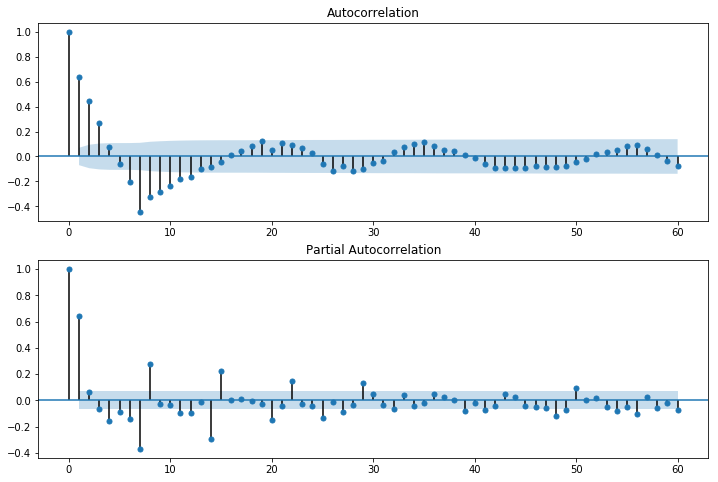

In [43]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfJoined2.residual, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfJoined2.residual, lags=60, ax=ax2)
plt.show()

In [44]:
from statsmodels.tsa.arima_model import ARIMA

### Research on what order of ARIMA to use in different cases

In [45]:
modelARIMA = ARIMA(dfCountStdFiltered.residual, order=(7,0,1))

In [46]:
model_fitARIMA = modelARIMA.fit(disp=0)
# print summary of fit model
print(model_fitARIMA.summary())

C:\Users\ayush.LAPTOP-A9620OED\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\ayush.LAPTOP-A9620OED\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:               residual   No. Observations:                  792
Model:                     ARMA(7, 1)   Log Likelihood               -5414.395
Method:                       css-mle   S.D. of innovations            224.970
Date:                Sat, 02 Feb 2019   AIC                          10848.790
Time:                        17:58:21   BIC                          10895.536
Sample:                    11-01-2016   HQIC                         10866.757
                         - 01-01-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.0478     12.705     -0.082      0.934     -25.949      23.853
ar.L1.residual     0.1428      0.051      2.826      0.005       0.044       0.242
ar.L2.residual     0.3053      0.039

In [47]:
# forecastARIMA = model_fitARIMA.forecast()
forecastARIMA = model_fitARIMA.forecast(steps=90)[0]

C:\Users\ayush.LAPTOP-A9620OED\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [48]:
start_index = pd.datetime(2018, 1, 28)
end_index = pd.datetime(2018, 4, 27)
forecastARIMA = model_fitARIMA.predict(start=start_index, end=end_index)

C:\Users\ayush.LAPTOP-A9620OED\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [49]:
dfARIMA = pd.DataFrame({'ARIMA' : model_fitARIMA.predict(start=start_index, end=end_index)})

C:\Users\ayush.LAPTOP-A9620OED\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


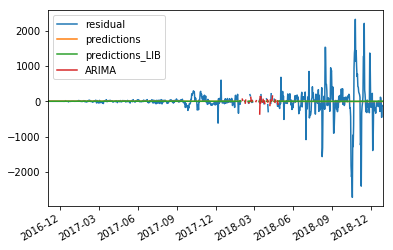

In [50]:
dfJoined2.append(dfARIMA)[['residual', 'predictions', 'predictions_LIB', 'ARIMA']].plot()
plt.show()

### TODO: Write inverse functions for trend and seasonality to get those back into the model.